In [1]:
%load_ext autoreload
%autoreload 2

import datajoint as dj

dj.config["display.limit"] = 50
dj.config["enable_python_native_blobs"] = True

dj.config['schema_name'] = "nnfabrik_color_mei"
schema = dj.schema("nnfabrik_color_mei")

from matplotlib import pyplot as plt
from torch import load

from nnfabrik.main import *

import nnfabrik
from collections import namedtuple
from nnfabrik import main, builder
import os
from os import listdir
from os.path import isfile, join
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

from mlutils.data.datasets import StaticImageSet, FileTreeDataset
from nndichromacy.tables.from_nnfabrik import TrainedModel, DataInfo
from dataport.bcm.static import PreprocessedMouseData
from nnvision.utility.measures import get_explainable_var

from nndichromacy.tables.from_mei import MEI, TrainedEnsembleModel, MEISelector, MEIMethod, MEISeed

import pandas as pd

Connecting kwilleke@134.2.168.16:3306


In [11]:
# zhuokuns datasets. V1/PM
dataset_hashes = ['1fac04c34cb6172afd6bab70cae291b0', 
                 '39cf1cde441c18adb9687ec5fa7cba43', 
                 '3c2020e3839a2e404d0a7bf965356c92',
                 'e94cabd55ab9284ddb4e25ad6cd4c7d5']

In [38]:
# Katrins scans, V1
dataset_hashes = ['ec0cd6e71c3ec7b4d718a509064f2ec2', 'ec261336c0e4116b13a6d8016b85d41a', 'a1d396d56a18398d9c133929ec64b806']

In [44]:
percentiles = [5,50,95]

perc_5 = []
perc_50 = []
perc_98 = []
dataset = []
pupil = []
dpupil=[]
treadmill=[]
all_behaviors=[]
behavior_type=[]

pupil_perc = []
dpupil_perc = []
treadmill_perc = []


for dataset_hash in dataset_hashes:
    dataloaders = (Dataset&dict(dataset_hash=dataset_hash)).get_dataloader(seed=10)
    dataset_name = (Dataset&dict(dataset_hash=dataset_hash)).fetch1("dataset_comment").split(" normali")[0]
    behaviors = []
    data_key = list(dataloaders["train"].keys())[0]
    for b in dataloaders["train"][data_key]:
        behaviors.append(b.images)
    if b.images.shape[1] == 4:
         behaviors = torch.cat(behaviors).cpu().numpy()[:,1:,0,0]
    else:
         behaviors = torch.cat(behaviors).cpu().numpy()[:,2:,0,0]
            
    dataset.extend([dataset_name]*3*behaviors.shape[0])

    all_behaviors.extend(behaviors[:,0])
    all_behaviors.extend(behaviors[:,1])
    all_behaviors.extend(behaviors[:,2])
    pupil.extend(behaviors[:,0])
    dpupil.extend(behaviors[:,1])
    treadmill.extend(behaviors[:,2])
    behavior_type.extend(['pupil']*behaviors.shape[0])
    behavior_type.extend(['dpupil']*behaviors.shape[0])
    behavior_type.extend(['treadmill']*behaviors.shape[0])
    
    pupil_perc.append([np.percentile(behaviors[:,0], i) for i in percentiles])
    dpupil_perc.append([np.percentile(behaviors[:,1], i) for i in percentiles])
    treadmill_perc.append([np.percentile(behaviors[:,2], i) for i in percentiles])

static24197-12-1-preproc0 exists already. Not unpacking static24197-12-1-preproc0.zip
static24046-15-6-preproc0 exists already. Not unpacking static24046-15-6-preproc0.zip
static24046-9-25-preproc0 exists already. Not unpacking static24046-9-25-preproc0.zip


In [45]:
df = pd.DataFrame({'normalized behavior': all_behaviors,
                   'behavior type': behavior_type,
                   'dataset': dataset,})

# Color MEI Data

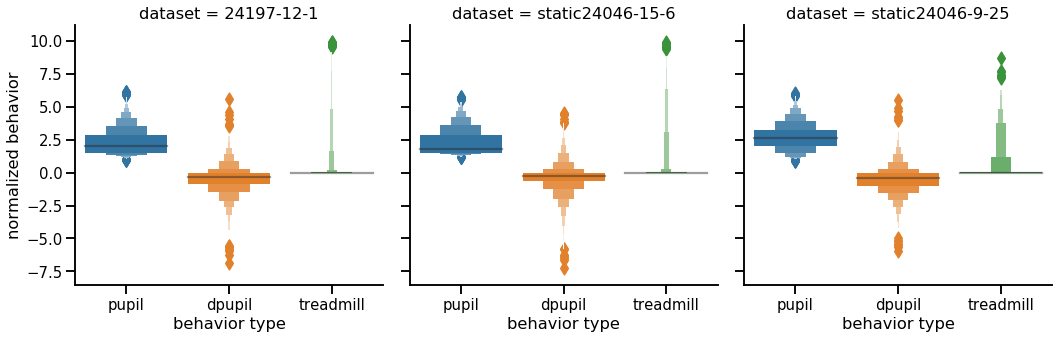

In [46]:
sns.set_context('talk', font_scale=0.9)

g = sns.catplot(x="behavior type", y="normalized behavior",col="dataset", kind="boxen", data=df[df["normalized behavior"]<10])

plt.savefig("behaviors_color_sessions.png", dpi=100, bbox_inches="tight")

# V1/PM Grayscale Data

#### run the above part again with zhuokuns dataset hashes

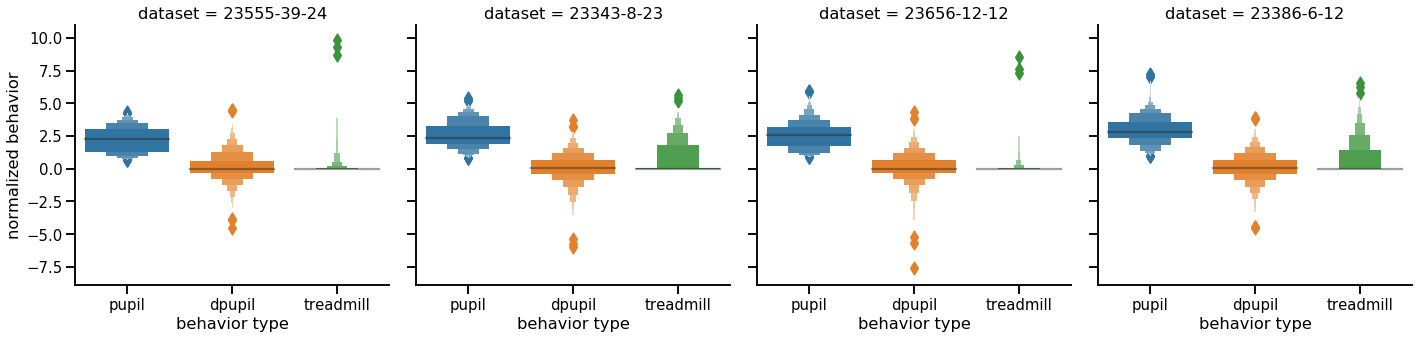

In [15]:
sns.set_context('talk', font_scale=0.9)

g = sns.catplot(x="behavior type", y="normalized behavior",col="dataset", kind="boxen", data=df[df["normalized behavior"]<10])

#plt.savefig("behaviors_across_sessions.png", dpi=100, bbox_inches="tight")

# Single Session

In [47]:
dataset_hash = 'ec0cd6e71c3ec7b4d718a509064f2ec2'

In [49]:
dataloaders = (Dataset&dict(dataset_hash=dataset_hash)).get_dataloader(seed=10)
data_key = list(dataloaders["train"].keys())[0]

behaviors = []
for b in dataloaders["train"][data_key]:
    behaviors.append(b.images)
if b.images.shape[1] == 4:
     behaviors = torch.cat(behaviors).cpu().numpy()[:,1:,0,0]
else:
     behaviors = torch.cat(behaviors).cpu().numpy()[:,2:,0,0]

static24197-12-1-preproc0 exists already. Not unpacking static24197-12-1-preproc0.zip


In [ ]:
# shape: pupil, dpupil, treadmill

In [50]:
behaviors.shape

(6276, 3)